In [1]:
import math
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import datetime as dt

if 'a_api' in sys.modules:
    del sys.modules['a_api']
if 'learn' in sys.modules:
    del sys.modules['learn']
if 'util' in sys.modules:
    del sys.modules['util']

from learn import count_ngrams_plus, count_ngrams_plus_tf_idf
from a_api import TextMetrics

model_family = 'babacan_shreevastava_multiclass'
if not os.path.exists('../../data/models/distortions/'+model_family+'/'):
    os.makedirs('../../data/models/distortions/'+model_family+'/')
for split_name in ['first_split','second_split','third_split']:
    split_path = '../../data/models/distortions/'+model_family+'/'+split_name+'/'
    if not os.path.exists(split_path):
        os.makedirs(split_path)

grand_t0 = dt.datetime.now()

def language_metrics(metrics_list, name_split_folder):
    metrics = {}
    for m in metrics_list:
        metrics[m] = f'../../data/models/distortions/{model_family}/{name_split_folder}/{m}.txt'
        #metrics[m] = './data/dict/' + 'en' + '/' + m + '.txt'
    return metrics

# Create Datasets
## Merge original binary and multiclass datasets into one

In [2]:
binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
# df3 = pd.concat([df3.iloc[:100], df3.iloc[-100:]], ignore_index=True) # hack for test
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


# Create training functions
### Functions for including key N-grams and creating model files

In [3]:
def ngrams_inclusion(model_ngram, ngram_inclusion_threshold):
    filtered_model_ngram = {}
    for distortion, ngram_dict in model_ngram.items():
        # Find the maximum metric value for the current distortion
        max_value = max(ngram_dict.values()) if ngram_dict else 0
        threshold_value = max_value * (ngram_inclusion_threshold / 100)

        # Filter n-grams that meet or exceed the threshold value
        filtered_model_ngram[distortion] = {
            ngram: metric for ngram, metric in ngram_dict.items() if metric >= threshold_value
        }
    return filtered_model_ngram


def create_model_files(filtered_model_ngram, name_split_folder):
    # Create .txt files for each distortion
    output_dir = f'../../data/models/distortions/{model_family}/{name_split_folder}'
    distortion_file_path = f"{output_dir}/All_distortions.txt"
    distortions_labels = []

    with open(distortion_file_path, "w", encoding="utf-8") as distortion_file:
        for distortion, ngrams in filtered_model_ngram.items():
            distortion_ = distortion.replace(" ", "_")
            file_path = f"{output_dir}/{distortion_}.txt"
            sorted_ngrams = sorted(ngrams.items(), key=lambda x: x[1], reverse=True) 
            distortions_labels.append(distortion_)
            with open(file_path, "w", encoding="utf-8") as f:
                for ngram, metric_value in sorted_ngrams:
                    ngram_str = ' '.join(ngram) 
                    f.write(f"{ngram_str}\t{metric_value}\n")
                    if distortion != "No Distortion":
                            distortion_file.write(f"{ngram_str}\t{metric_value}\n")

    old_distortion_file = f"{output_dir}/Distortion.txt"
    os.remove(old_distortion_file)
    os.rename(distortion_file_path, old_distortion_file)
    
    return (list(set(distortions_labels) - {'No_Distortion'}))
    #return (list(set(distortions_labels)))

### Evaluate functions

In [4]:
def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_df_counts(df,evaluator,threshold, tm, debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(text,threshold, tm)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,text[:20],metrics)

    return true_positive, true_negative, false_positive, false_negative

def evaluate_df(df,evaluator,threshold,tm, debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative)

def evaluate_df_acc_f1(df,evaluator,threshold,tm,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,evaluator,threshold,tm,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def our_evaluator_any(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_avg(text,threshold, tm):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

### Functions for analyzing the dataset and plot heatmaps

In [5]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title=None, subtitle=None, vmin=None, vmax=None, dpi=None, titlefontsize=None, subtitlefontsize=None, width=20):
    plt.rcParams["figure.figsize"] = (width, len(row_labels) / 4)
    if dpi is not None:
        plt.rcParams["figure.dpi"] = dpi

    fig, ax = plt.subplots()

    p = sns.heatmap(matrix, ax=ax, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin=-absmax if vmin is None else vmin, 
                    vmax=absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        ax.set_title(title, fontsize=titlefontsize, pad=20)

    if subtitle is not None:
        if subtitlefontsize is None:
            subtitlefontsize = round(titlefontsize * 0.7)
        ax.text(0.5, 1.01, subtitle, fontsize=subtitlefontsize, ha='center', va='bottom', transform=ax.transAxes)

    plt.show()    


def analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, df_train, df_test, name_split_folder, print_or_plot):
    
    if name_split_folder == 'first_split' and print_or_plot == 'print_results':
        print('\nN-gram selection metric:', ngram_selection_metric)
        print('N-gram max length:', ngram_max)
        print('N-gram inclusion threshold:', ngram_inclusion_threshold)

    if ngram_selection_metric == 'TF-IDF':
        model_ngram = count_ngrams_plus_tf_idf(df_train,ngram_max,binary=False)
    
    elif ngram_selection_metric in ['F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        distortions, frequency, all_n_grams, frequency_self_normalized, unique_frequency, uniq_all_n_grams, n_gram_distortions, \
        norm_uniq_n_gram_dicts, n_gram_distortions_counts, norm, unique_frequency_self_normalized, norm_norm_uniq, norm_norm_uniq_norm, \
        norm_norm_uniq_norm_norm, fcr, cfr, mr, nl_mi, N = count_ngrams_plus(df_train,ngram_max,binary=False)
        
        selection_metrics = {
            'F':frequency,
            'UF':unique_frequency,
            'FN':frequency_self_normalized,
            'UFN':unique_frequency_self_normalized,
            'CFR':cfr,
            'FCR':fcr,
            'MR':mr,
            'NLMI':nl_mi}
        
        model_ngram = selection_metrics[ngram_selection_metric]

    # Filter out values below the threshold
    filtered_model_ngram = ngrams_inclusion(model_ngram, ngram_inclusion_threshold)

    # Create .txt files for each distortion
    distortions_labels = create_model_files(filtered_model_ngram, name_split_folder)
    tm = TextMetrics(language_metrics(distortions_labels, name_split_folder), encoding = "utf-8", debug=False)

    if print_or_plot == 'print_results':
        if name_split_folder == 'first_split':
            print('\tFIRST COMBINATION')
        elif name_split_folder == 'second_split':
            print('\n\tSECOND COMBINATION')
        elif name_split_folder == 'third_split':
            print('\n\tTHIRD COMBINATION')

    if print_or_plot == 'print_results':
        print('\t\tAny distortion (threshold, accuracy, F1 score):')
    any_res_acc = {}
    any_res = {}
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_any,threshold, tm)
        any_res_acc[threshold] = acc
        any_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    avg_res_acc = {}
    avg_res = {}
    if print_or_plot == 'print_results':
        print('\n\t\tAverage distortion (threshold, accuracy, F1 score):')
    for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        acc, f1 = evaluate_df_acc_f1(df_test,our_evaluator_avg,threshold, tm)
        avg_res_acc[threshold] = acc
        avg_res[threshold] = f1
        if print_or_plot == 'print_results':
            print('\t\t', threshold, acc, f1)

    return any_res_acc, avg_res_acc


# Grid search
### Perform a grid search over all hyper-parameters to determine the best combination for building the model

In [6]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_tv = df3[df3.index % 10 != 0]
print('Train and valid',len(df_tv))
df_valid = df_tv[df_tv.index % 10 == 1]
print('Valid set',len(df_valid))
df_train = df_tv[(df_tv.index % 10 != 0) & (df_tv.index % 10 != 1)]
print('Train set',len(df_train))

splits = [
        (df_train, df_valid)
        #(pd.concat([part1, part2]), part3),  # (1 + 2) -> train, (3) -> test
        #(pd.concat([part1, part3]), part2),  # (1 + 3) -> train, (2) -> test
        #(pd.concat([part2, part3]), part1)   # (2 + 3) -> train, (1) -> test
]

Full set 6057
Test set 606
Train and valid 5451
Valid set 606
Train set 4845


In [7]:
def grid_search(splits):
    best_param_any = None
    best_acc_any = 0
    best_param_avg = None
    best_acc_avg = 0
    for ngram_selection_metric in ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']:
        for ngram_max in range (1, 5):
            for ngram_inclusion_threshold in [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]:
                all_values_any = []
                all_values_avg = []
                for i, (train_df, test_df) in enumerate(splits, start=1):
                    if i == 1:
                        first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'print_results')
                        all_values_any += list(first_split_acc_any.values())
                        all_values_avg += list(first_split_acc_avg.values())                        
                    elif i == 2:
                        second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'print_results')
                        all_values_any += list(second_split_acc_any.values())
                        all_values_avg += list(second_split_acc_avg.values())                        
                    elif i == 3:
                        third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, ngram_max, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'print_results')
                        all_values_any += list(third_split_acc_any.values())
                        all_values_avg += list(third_split_acc_avg.values())                        
                                
                min_value = round(min(all_values_any),3)
                max_value = round(max(all_values_any),3)
                mean_value = round(np.mean(all_values_any),3)

                if best_acc_any < max_value:
                    best_acc_any = max_value
                    best_param_any = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\t(Any distortion) Min acc: {min_value}\tMax acc: {max_value}\tMean acc: {mean_value}\tBest acc: {best_acc_any}\tHyper-parameters: {str(best_param_any)}")

                min_value = round(min(all_values_avg),3)
                max_value = round(max(all_values_avg),3)
                mean_value = round(np.mean(all_values_avg),3)

                if best_acc_avg < max_value:
                    best_acc_avg = max_value
                    best_param_avg = (ngram_selection_metric, ngram_max, ngram_inclusion_threshold)

                print(f"\t(Avg distortion) Min acc: {min_value}\tMax acc: {max_value}\tMean acc: {mean_value}\tBest acc: {best_acc_avg}\tHyper-parameters: {str(best_param_avg)}")

    print(f"(Any distortion)Best mean accuracy: {best_acc_any}\tHyper-parameters: {str(best_param_any)}")
    print(f"(Average distortion)Best mean accuracy: {best_acc_avg}\tHyper-parameters: {str(best_param_avg)}")
    return best_param_any, best_param_avg

In [8]:
best_param_any, best_param_avg = grid_search(splits)


N-gram selection metric: TF-IDF
N-gram max length: 1
N-gram inclusion threshold: 90
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.636963696369637 0.65625
		 0.2 0.6221122112211221 0.634768740031898
		 0.3 0.5726072607260726 0.5632377740303541
		 0.4 0.5148514851485149 0.47311827956989244
		 0.5 0.41914191419141916 0.296
		 0.6 0.37293729372937295 0.19491525423728814
		 0.7 0.3184818481848185 0.0592255125284738
		 0.8 0.297029702970297 0
		 0.9 0.297029702970297 0

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.636963696369637 0.65625
		 0.2 0.6221122112211221 0.634768740031898
		 0.3 0.5726072607260726 0.5632377740303541
		 0.4 0.5148514851485149 0.47311827956989244
		 0.5 0.41914191419141916 0.296
		 0.6 0.37293729372937295 0.19491525423728814
		 0.7 0.3184818481848185 0.0592255125284738
		 0.8 0.297029702970297 0
		 0.9 0.297029702970297 0
	(Any distortion) Min acc: 0.297	Max acc: 0.637	Mean acc: 0.45	Best acc: 0.637	Hyper-parameters: 

### Our best model obtained through the optimal combination of hyper-parameters

In [9]:
best_sm, best_nm, best_it = best_param_avg
print(best_sm, best_nm, best_it)

FN 4 50


# Plot heatmaps 
## Plot heatmaps illustrating the search for optimal hyperparameters

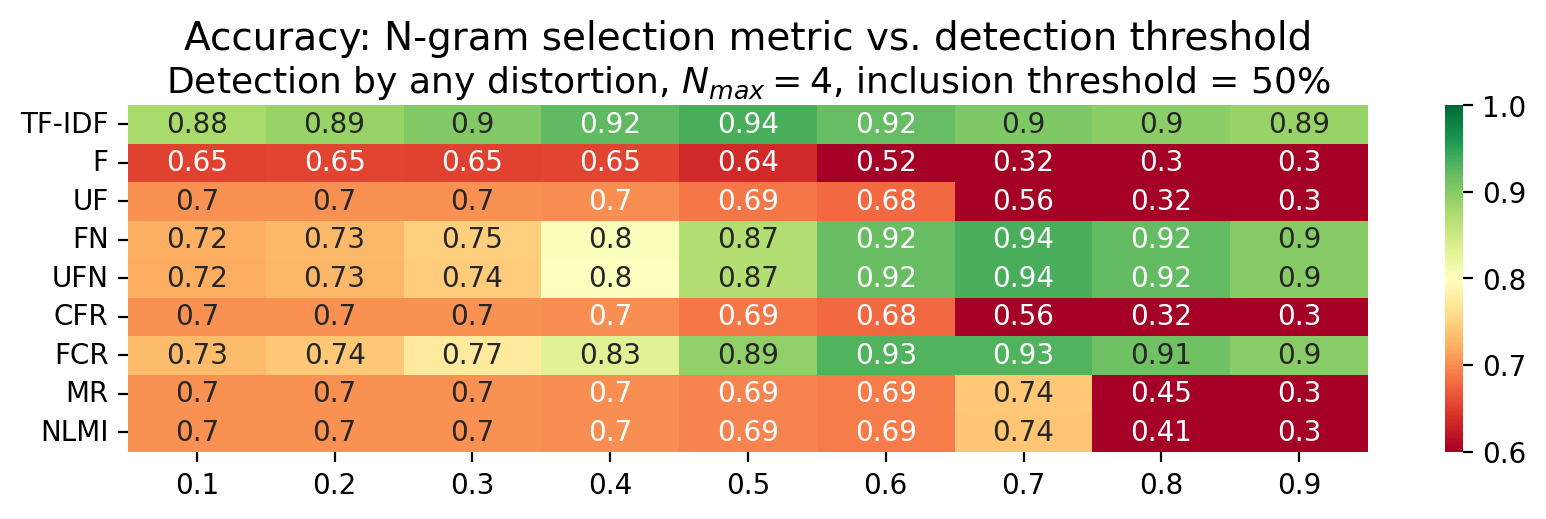

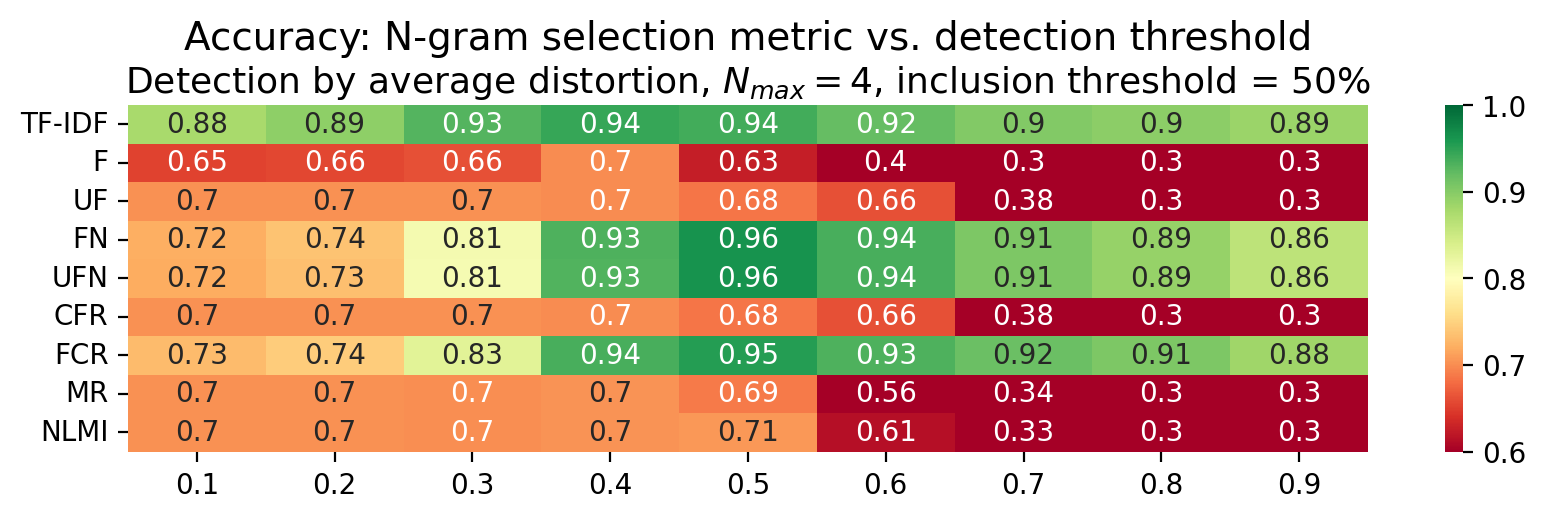

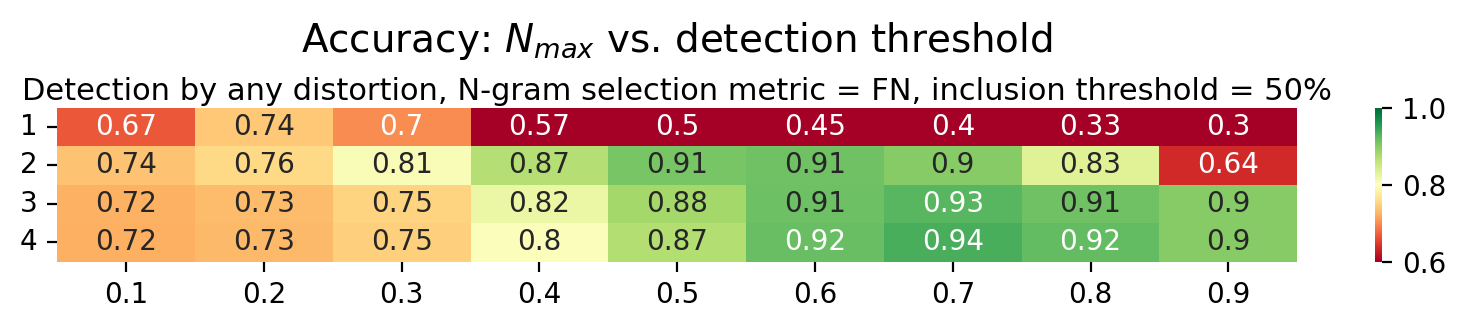

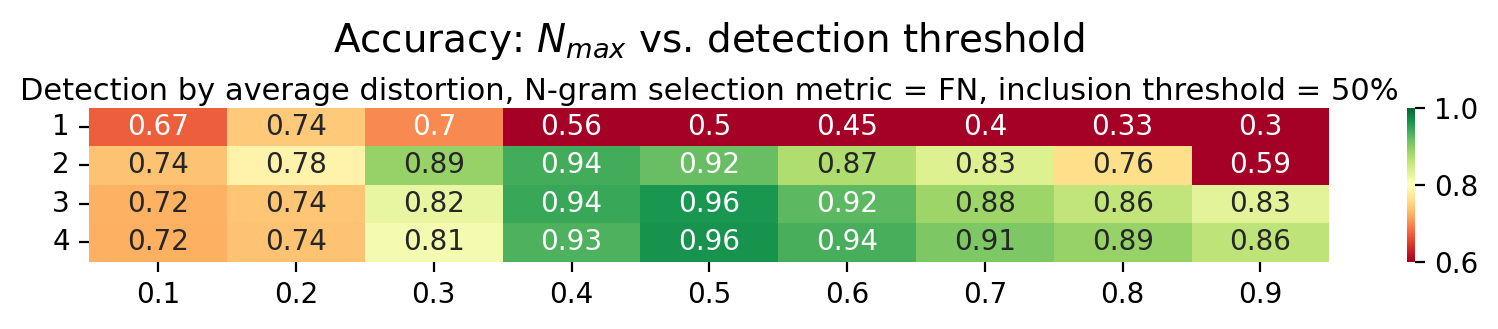

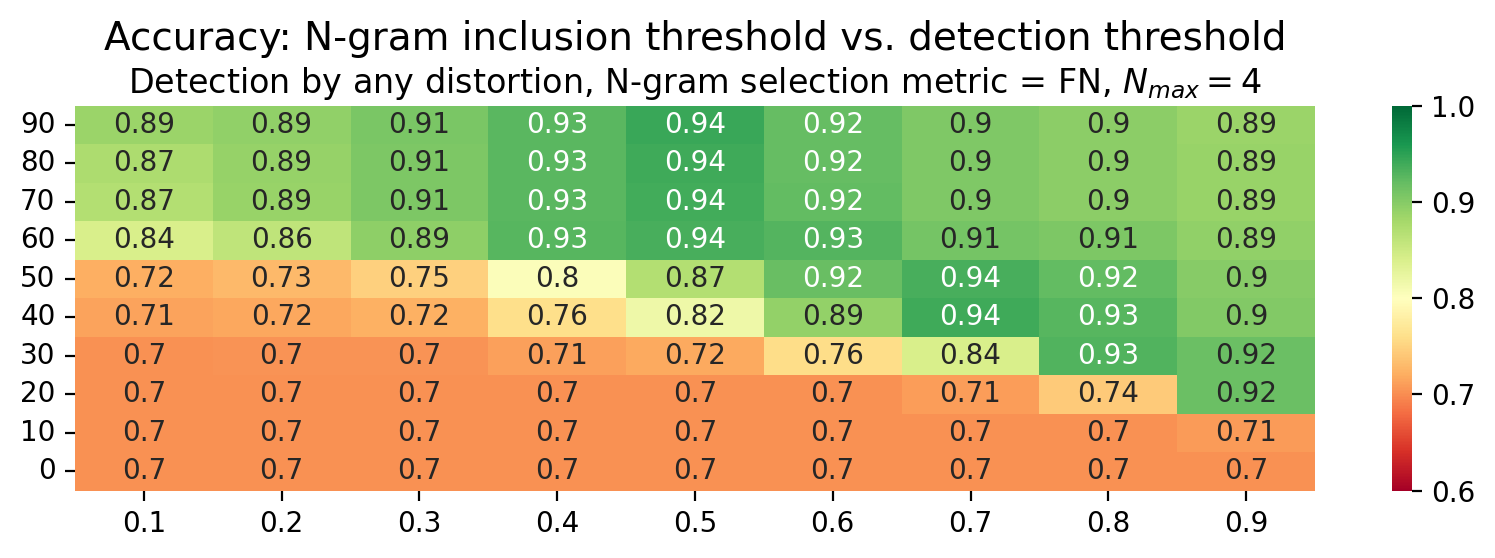

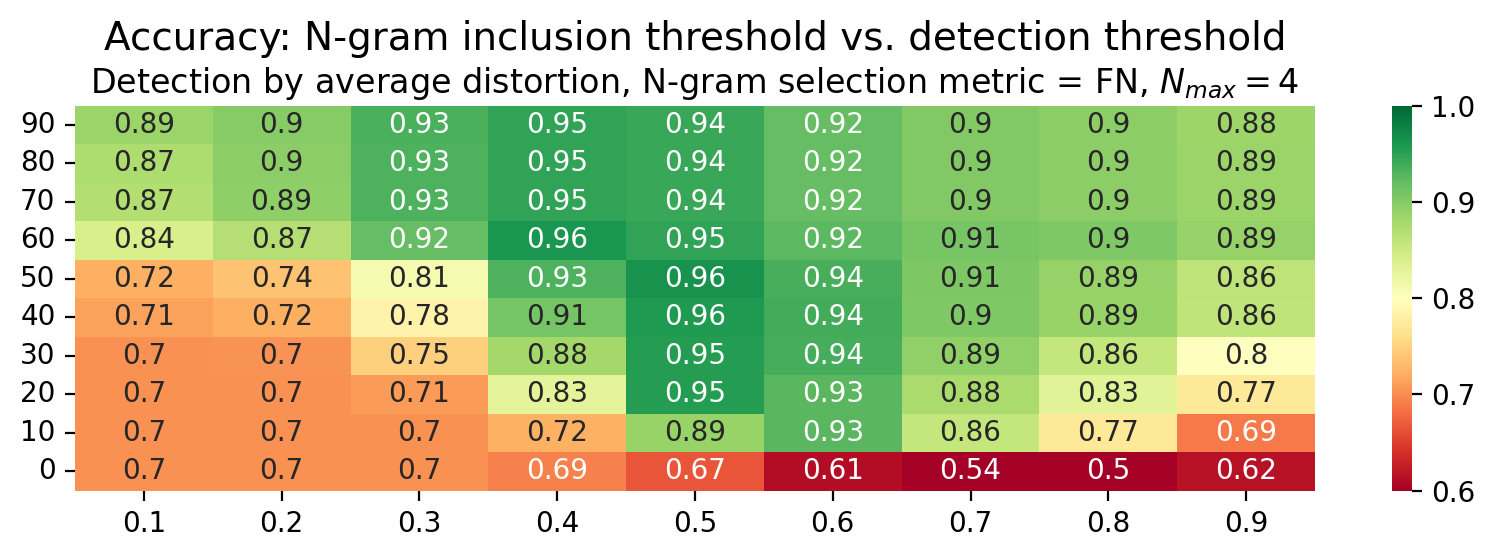

In [10]:
ngram_selection_metrics = ['TF-IDF','F','UF','FN','UFN','CFR','FCR','MR','NLMI']
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ngram_max_values = [1, 2, 3, 4]
ngram_inclusion_thresholds = [90, 80, 70, 60, 50, 40, 30, 20, 10, 0]


# 1) N-gram selection metric - threshold
acc_analytics_threshold_any = np.zeros((len(ngram_selection_metrics), len(thresholds)))
acc_analytics_threshold_avg = np.zeros((len(ngram_selection_metrics), len(thresholds)))

for i, ngram_selection_metric in enumerate(ngram_selection_metrics):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(ngram_selection_metric, best_nm, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3  if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_analytics_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_analytics_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_any, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by any distortion, $N_{max}="+str(best_nm)+"$, inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)

matrix_plot(
    ngram_selection_metrics, thresholds, acc_analytics_threshold_avg, 1.0,
    title="Accuracy: N-gram selection metric vs. detection threshold",
    subtitle="Detection by average distortion, $N_{max}="+str(best_nm)+"$, inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=13,
    dpi=200, width=10
)



# 2) ngram_max - threshold
acc_ngrammax_threshold_any = np.zeros((len(ngram_max_values), len(thresholds)))
acc_ngrammax_threshold_avg = np.zeros((len(ngram_max_values), len(thresholds)))

for i, ngram_max in enumerate(ngram_max_values):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, ngram_max, best_it, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3  if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3  if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngrammax_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngrammax_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_any, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = "+best_sm+", inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)

matrix_plot(
    ngram_max_values, thresholds, acc_ngrammax_threshold_avg, 1.0,
    title="Accuracy: $N_{max}$ vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = "+best_sm+", inclusion threshold = "+str(best_it)+"%",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=11,
    dpi=200, width=10
)



# 3) ngram_inclusion_threshold - threshold
acc_ngram_inclusion_threshold_any = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))
acc_ngram_inclusion_threshold_avg = np.zeros((len(ngram_inclusion_thresholds), len(thresholds)))

for i, ngram_inclusion_threshold in enumerate(ngram_inclusion_thresholds):

    for k, (train_df, test_df) in enumerate(splits, start=1):
        if k == 1:
            first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'first_split', 'plot_results')
        elif k == 2:
            second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'second_split', 'plot_results')
        elif k == 3:
            third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, best_nm, ngram_inclusion_threshold, train_df, test_df, 'third_split', 'plot_results')

    average_acc_data_any = {
    key: (first_split_acc_any[key] + second_split_acc_any[key] + third_split_acc_any[key]) / 3 if len (splits) == 3 else first_split_acc_any[key]
    for key in first_split_acc_any
    }

    average_acc_data_avg = {
    key: (first_split_acc_avg[key] + second_split_acc_avg[key] + third_split_acc_avg[key]) / 3 if len (splits) == 3 else first_split_acc_avg[key]
    for key in first_split_acc_avg
    }

    for j, threshold in enumerate(thresholds):
        acc_ngram_inclusion_threshold_any[i, j] = average_acc_data_any[threshold]
        acc_ngram_inclusion_threshold_avg[i, j] = average_acc_data_avg[threshold]

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_any, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by any distortion, N-gram selection metric = "+best_sm+", $N_{max}="+str(best_nm)+"$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

matrix_plot(
    ngram_inclusion_thresholds, thresholds, acc_ngram_inclusion_threshold_avg, 1.0,
    title="Accuracy: N-gram inclusion threshold vs. detection threshold",
    subtitle="Detection by average distortion, N-gram selection metric = "+best_sm+", $N_{max}="+str(best_nm)+"$",
    vmin=1.0 - (1.0 - 0.8) * 2, vmax=1.0, titlefontsize=14, subtitlefontsize=12,
    dpi=200, width=10
)

### Our best model obtained through the optimal combination of hyper-parameters

In [11]:
for i, (train_df, test_df) in enumerate(splits, start=1):
    if i == 1:
        first_split_acc_any, first_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'first_split', 'print_results')
    elif i == 2:
        second_split_acc_any, second_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'second_split', 'print_results')
    elif i == 3:
        third_split_acc_any, third_split_acc_avg = analyse_dataset(best_sm, best_nm, best_it, train_df, test_df, 'third_split', 'print_results')



N-gram selection metric: FN
N-gram max length: 4
N-gram inclusion threshold: 50
	FIRST COMBINATION
		Any distortion (threshold, accuracy, F1 score):
		 0.1 0.7211221122112211 0.8341511285574092
		 0.2 0.7293729372937293 0.8382642998027613
		 0.3 0.7475247524752475 0.8474576271186439
		 0.4 0.8036303630363036 0.8766839378238342
		 0.5 0.8696369636963697 0.9140369967355821
		 0.6 0.9174917491749175 0.942528735632184
		 0.7 0.9356435643564357 0.9529553679131484
		 0.8 0.9207920792079208 0.9405940594059407
		 0.9 0.8993399339933993 0.922882427307206

		Average distortion (threshold, accuracy, F1 score):
		 0.1 0.7211221122112211 0.8341511285574092
		 0.2 0.735973597359736 0.8415841584158416
		 0.3 0.8118811881188119 0.8817427385892117
		 0.4 0.9323432343234324 0.9536723163841807
		 0.5 0.9636963696369637 0.9738095238095238
		 0.6 0.9356435643564357 0.9521472392638037
		 0.7 0.905940594059406 0.9283018867924528
		 0.8 0.8894389438943895 0.9146496815286624
		 0.9 0.8613861386138614 0.890625

In [14]:
best_param_avg

('FN', 4, 50)

In [13]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'9:57:21.609266'